In [1]:
# Import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import multiprocessing
import timeit

from sklearn.impute import KNNImputer
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import  train_test_split
from imblearn.combine import SMOTETomek

In [2]:
def balanced_test_split(X, y, n_samples=10, seed=1):
    test_idx = np.array([])

    for n in  y.unique():
        test_idx = np.concatenate([test_idx, X[y == n].sample(n_samples, random_state=seed).index], axis=0)
        
    X_v = X.loc[test_idx, :]
    y_v = y[test_idx]
    X_t = X.drop(index=test_idx)
    y_t = y.drop(index=test_idx)

    return (X_t, y_t, X_v, y_v)

In [3]:
data = pd.read_csv('datasets/dataset_clean.csv')
data = data.drop('slope', axis = 1)
X_test = pd.read_csv('datasets/test_dataset_clean.csv')
#X_test = X_test.drop('risks', axis = 1)

data_us = data.copy()
data_us = data_us.drop(data_us[(data_us['label'] == 0) & ( (data_us['risks'] >= 5 ) ) ].index) ## Los que label sea 0 y que el riesgo sea mayor o iagual a 5
data_us = data_us.drop(data_us[(data_us['label'] == 1) & ( (data_us['risks'] >= 11 ) ) ].index) ## Los que label sea 1 y que el riesgo sea mayor o iagual a 7
data_us = data_us.drop(data_us[(data_us['label'] != 0) & (data_us['risks'] <= 1)].index) ## Los que label sea distinta de 0 y que el riesgo sea menor o igual que 1
data_us = data_us.drop(data_us[(data_us['risks'] == 0) & (data_us['label'] != 0)].index) ## Los que no tengan riesgo y que su label sea distinta de 0
data_us = data_us.reset_index(drop=True)
#data_us = data.drop('risks', axis = 1)
data_us.shape 
# 741, 23

(747, 22)

In [4]:
data_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           747 non-null    float64
 1   sex           747 non-null    float64
 2   cp            747 non-null    float64
 3   trestbps      747 non-null    float64
 4   chol          747 non-null    float64
 5   fbs           747 non-null    float64
 6   restecg       747 non-null    float64
 7   thalach       747 non-null    float64
 8   exang         747 non-null    float64
 9   oldpeak       747 non-null    float64
 10  ca            747 non-null    float64
 11  thal          747 non-null    float64
 12  num_na_count  747 non-null    int64  
 13  cat_na_count  747 non-null    int64  
 14  na_count      747 non-null    int64  
 15  age2          747 non-null    float64
 16  oldpeak2      747 non-null    int64  
 17  thalach_max   747 non-null    float64
 18  thalach_diff  747 non-null    

In [5]:
categorical_vars = ['sex', 'exang', 'thal', 'fbs', 'restecg',  'cp', 'ca'] 
numerical_vars = ['age', 'trestbps', 'chol',  'thalach_diff', 'oldpeak', 'num_na_count', 'cat_na_count', 'thalach_max'] #'oldpeak_diff', 'thalach',

X = data_us
y = data_us['label']
X = X.drop('label', axis = 1)

X[categorical_vars] = (X[categorical_vars].astype(int)) # minmax_scale
X[numerical_vars] = scale(X[numerical_vars])
X = pd.concat([X[numerical_vars],X[categorical_vars]], axis=1)

X_test[categorical_vars] = (X_test[categorical_vars].astype(int)) # minmax_scale
X_test[numerical_vars] = scale(X_test[numerical_vars])
X_test = pd.concat([X_test[numerical_vars], X_test[categorical_vars]], axis=1)

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           747 non-null    float64
 1   trestbps      747 non-null    float64
 2   chol          747 non-null    float64
 3   thalach_diff  747 non-null    float64
 4   oldpeak       747 non-null    float64
 5   num_na_count  747 non-null    float64
 6   cat_na_count  747 non-null    float64
 7   thalach_max   747 non-null    float64
 8   sex           747 non-null    int32  
 9   exang         747 non-null    int32  
 10  thal          747 non-null    int32  
 11  fbs           747 non-null    int32  
 12  restecg       747 non-null    int32  
 13  cp            747 non-null    int32  
 14  ca            747 non-null    int32  
dtypes: float64(8), int32(7)
memory usage: 67.2 KB


In [7]:
# ahora aplicamos OHE a las variables categóricas
ohe = OneHotEncoder(drop= 'first', sparse = False)

ohe_fit = ohe.fit(X[categorical_vars])
ohe_fit_test = ohe.fit(X_test[categorical_vars])

X_ohe = pd.DataFrame(ohe.fit_transform(X[categorical_vars]))
X_ohe_test = pd.DataFrame(ohe.fit_transform(X_test[categorical_vars]))

X_ohe.columns = ohe_fit.get_feature_names_out()
X_ohe_test.columns = ohe_fit_test.get_feature_names_out()


X = pd.concat((X_ohe, X[numerical_vars].reset_index()), axis=1)
X_test = pd.concat((X_ohe_test, X_test[numerical_vars].reset_index()), axis=1)

X.set_index('index')
X_test.set_index('index')

X.drop('index', axis=1, inplace=True)
X_test.drop('index', axis=1, inplace=True)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sex_1         747 non-null    float64
 1   exang_2       747 non-null    float64
 2   thal_3        747 non-null    float64
 3   thal_6        747 non-null    float64
 4   thal_7        747 non-null    float64
 5   fbs_1         747 non-null    float64
 6   fbs_2         747 non-null    float64
 7   restecg_1     747 non-null    float64
 8   restecg_2     747 non-null    float64
 9   restecg_3     747 non-null    float64
 10  cp_2          747 non-null    float64
 11  cp_3          747 non-null    float64
 12  cp_4          747 non-null    float64
 13  ca_1          747 non-null    float64
 14  ca_2          747 non-null    float64
 15  ca_3          747 non-null    float64
 16  ca_4          747 non-null    float64
 17  age           747 non-null    float64
 18  trestbps      747 non-null    

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed 

In [8]:
# Aplicamos SMOTE y dividimos el dataset en train y validación
sm = SMOTE(sampling_strategy={4: 93}, random_state = 1, k_neighbors = 3) 
Xsm, ysm = sm.fit_resample(X, y)

X_train, y_train, X_val, y_val = balanced_test_split(Xsm, ysm, n_samples=10, seed=765)

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(757, 25)
(757,)
(50, 25)
(50,)


### Modelos

In [10]:
!pip install lightgbm --upgrade

In [11]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [12]:
scale_pos_weight = sum(np.array(y_train == 0)) / sum(np.array(y_train == 4))

In [13]:
# Metric import
from sklearn.metrics import f1_score as metric

In [14]:
#Hay que transformar los datasets a un formato específico
X_train.columns = ["var_" + str(x) for x in range(X.shape[1])]
X_val.columns = ["var_" + str(x) for x in range(X.shape[1])]
X_test.columns = ["var_" + str(x) for x in range(X.shape[1])]
train_data = lgb.Dataset(data = X_train, label = y_train)
validation_data = train_data.create_valid(data = X_val, label = y_val)

In [15]:
lgbm = lgb.LGBMClassifier(objective = 'multiclass',
                         metric = 'multi_logloss',
                         is_unbalance = True,
                         num_class = 5)

# Entrenamos el modelo (no usamos constructor + fit, sino lgb.train)
param = {'num_iterations': [55],
         'min_gain_to_split': [0],
         'subsample': [0.9],
         'num_leaves': [32],
         'feature_fraction': [0.8],
         'scale_pos_weight': [scale_pos_weight],
         'max_depth': [5],
         'boosting_type': ['gbdt'], #GradientBoostingDecisionTree
         'learning_rate': [0.075]}

grid = GridSearchCV(estimator = lgbm,
                    param_grid=param,
                    scoring = 'f1_micro',
                    n_jobs = multiprocessing.cpu_count()-1,
                    verbose=True
                   )

grid.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(stopping_rounds = 6)])

print(f'Best params : {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
Training until validation scores don't improve for 6 rounds
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 1.1855
Best params : {'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.075, 'max_depth': 5, 'min_gain_to_split': 0, 'num_iterations': 55, 'num_leaves': 32, 'scale_pos_weight': 3.566265060240964, 'subsample': 0.9}
Best score: 0.5747211571976298


C:\Users\Usuario\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [16]:
#best_config =  {'alpha': 1, 'colsample_bytree': 0.1, 'learning_rate': 0.99, 'gamma': 1, 'lambda': 1, 'max_depth': 6, 
#                'min_child_weight': 20, 'n_estimators': 300, 'subsample': 1}

best_config = grid.best_params_

param = {'objective' : 'multiclass',
        'metric' : 'multi_logloss',
        'num_class' : 5,
        'num_iterations' : best_config['num_iterations'],
        'min_gain_to_split' : best_config['min_gain_to_split'],
        'subsample' : best_config['subsample'],
        'feature_fraction' : best_config['feature_fraction'],
        'scale_pos_weight' : best_config['scale_pos_weight'],
        'max_depth' : best_config['max_depth'],
        'boosting_type' : best_config['boosting_type'],
        'learning_rate' : best_config['learning_rate']}

model = lgb.train(param, train_data, valid_sets=[validation_data], callbacks=[lgb.early_stopping(stopping_rounds=6)])

pred_y_train = model.predict(X_train) 
pred_y_val = model.predict(X_val) 
pred_y_test = model.predict(X_test) 

y_train_labels = pred_y_train.argmax(axis=1)
y_val_labels = pred_y_val.argmax(axis=1)
y_test_labels = pred_y_test.argmax(axis=1)

print(f"F1 score (train): {f1_score(y_train, y_train_labels, average='micro')}")
print(f"F1 score (val): {f1_score(y_val, y_val_labels, average='micro')}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 757, number of used features: 25
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -0.939004
[LightGBM] [Info] Start training from score -1.573117
[LightGBM] [Info] Start training from score -1.947232
[LightGBM] [Info] Start training from score -1.901975
[LightGBM] [Info] Start training from score -2.210523
[LightGBM] [Warning] No further splits with positiv

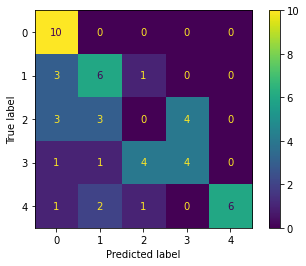

In [17]:
conf_matrix = confusion_matrix(y_val, y_val_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

In [18]:
# Generamos df pred
pred_df = pd.DataFrame({'ID': range(0, 50), 'label': y_test_labels.astype(int)})
pred_df.to_csv('submissions/submission_LGBM8.csv', index=False)